In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta  


In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

Executed query and closed connection.


In [3]:
query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.


In [4]:
class bad_con_obs:
    
    def __init__(self, T, epsilon, dates, counts):
        
        self.T = int(2**np.ceil(np.log2(T)))
        self.epsilon = epsilon
        self.zeta = (np.log2(T))/epsilon
        self.dates = dates
        self.n_layers = int(np.log2(self.T))
        values = np.arange(0,len(dates))
        zip_iterator = zip(dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.real_counts = counts
        
        self.noise_counts = self.__process(self.real_counts)
        
        
    
    def __process(self, dates):
        noise_counts = np.zeros(len(dates))
        
        for idx, date_count in enumerate(counts):
            laplace_sum = np.sum(laplace(scale=self.zeta).rvs(int(np.ceil(np.log2(1794)))))
            noise_counts[idx] = date_count + laplace_sum + noise_counts[idx-1]
            
        return noise_counts
    
    def answer(self, dates):
        
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            #print(date_obj_0)
            #print(type(date_obj_0))
            idx = self.idx_dict[date_obj_0]
            #Index is not 0
            if idx:
                return self.noise_counts[idx] - self.noise_counts[idx-1]            
            else:
                return self.noise_counts[idx]
        else:
            """
            print(self.noise_counts[0:4])
            print(self.noise_counts[self.idx_dict[dates[0]]])
            print(self.noise_counts[self.idx_dict[dates[1]]] )
            print(f'date_obj_0 idx = {self.idx_dict[date_obj_0]}')
            print(f'date_obj_1 idx = {self.idx_dict[date_obj_1]}')
            print(f'noise_counts[{self.idx_dict[date_obj_0]}] = {self.noise_counts[self.idx_dict[date_obj_0]]}')
            print(f'noise_counts[{self.idx_dict[date_obj_1]}] = {self.noise_counts[self.idx_dict[date_obj_1]]}')
            """
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            
            idx_0 = self.idx_dict[date_obj_0]
            idx_1 = self.idx_dict[date_obj_1]
            
            #idx_0 is not 0
            if idx_0:
                return self.noise_counts[idx_1] - self.noise_counts[idx_0-1]            
            else:
                return self.noise_counts[idx_1]
        
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.real_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            sum_ = np.sum(self.real_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_
        
class con_obs:
    
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere

        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.dates = dates
        self.real_counts = counts
        #Check if we are we have missing dates.
        if len(dates) < (dates[-1]-dates[0]).days:  
            self.dates = self.__add_missing_dates(dates)
            self.real_counts = self.__add_missing_counts(counts,dates)
            
        
        #Make dict for date indexing
        values = np.arange(0,len(self.dates))
        zip_iterator = zip(self.dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        
        
        
        # We need the stream to be a power of 2
        self.T = int(2**np.ceil(np.log2(len(self.dates))))
        self.epsilon = epsilon
        self.zeta = (np.log2(self.T))/epsilon
        # The height of the "Binary tree"
        self.n_layers = int(np.log2(self.T))
        
        # Get laplace for each node
        self.laplaces = self.__init_laplace()
        self.noise_counts = self.__process(self.real_counts)
        
        
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __init_laplace(self):
        """
        returns: list of arrays with the correct size of laplaces variabels.
        """
        laplaces = []
        for i in np.arange(0,self.n_layers+1):
            rvs = laplace(scale=self.zeta).rvs(int(2**np.ceil(i)))
            laplaces.append(rvs)
        
        return laplaces
    
    
    def __process(self, counts):
               
        noise_counts = np.zeros(len(self.dates))
        for idx, date_count in enumerate(counts):
            indices = self.get_index(idx,self.n_layers)
            indices.reverse()
            laplace_sum = 0.0
            for laplace_idx, laplace_row in enumerate(self.laplaces):
                laplace_sum = laplace_sum + laplace_row[indices[laplace_idx]]
            noise_counts[idx] = date_count  +  noise_counts[idx-1] + laplace_sum
        return noise_counts
    
    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up
        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//2))
        idx.append(0)
        return idx
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        if (len(dates) < 2):
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            #print(date_obj_0)
            #print(type(date_obj_0))
            idx = self.idx_dict[date_obj_0]
            if idx:
                #Index is not 0
                return self.noise_counts[idx] - self.noise_counts[idx-1]            
            else:
                return self.noise_counts[idx]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            idx_0 = self.idx_dict[date_obj_0]
            idx_1 = self.idx_dict[date_obj_1]
            
            #idx_0 is not 0
            if idx_0:
                return self.noise_counts[idx_1] - self.noise_counts[idx_0-1]            
            else:
                return self.noise_counts[idx_1]
            
        
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.real_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            sum_ = np.sum(self.real_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_

        
        

T = len(dates)
epsilon = 0.7
c_o = con_obs(epsilon, dates, counts)

In [5]:
T = len(dates)
epsilon = 0.7
c_o = bad_con_obs(T, epsilon, dates, counts)
print(c_o.answer(('2014-01-02','2014-01-05')))
print(c_o.real_answer(('2014-01-02','2014-01-05')))

print(c_o.answer(('2014-01-20',)))
print(c_o.real_answer(('2014-01-20',)))

508.57933189004626
488
212.05310969032735
315


In [6]:
for i in np.arange(50,10000,50):
    print(i)
    print(np.mean(laplace(scale=(np.log2(1000))/epsilon).rvs(i)))

50
1.6893729083136464
100
1.625303255222653
150
0.2779112008399114
200
-2.0730911862808887
250
-2.715708719720884
300
1.6616345935981534
350
-1.1173494788048022
400
0.8752273186049396
450
0.21784415822782235
500
1.7300710118768816
550
-0.03271471923977422
600
1.0245868579418482
650
-0.9966637682470444
700
0.814234849503461
750
-0.5090292813090093
800
-1.0202333951189926
850
1.7452470854647548
900
0.9355095462560596
950
0.01982459256433147
1000
1.0455923590265273
1050
-0.670507965050561
1100
-0.3286719704381489
1150
0.7100510732341012
1200
0.27469545010951035
1250
-0.2682135516755635
1300
-0.3567953188586699
1350
-0.6633348836144759
1400
0.4249540075515129
1450
0.16546281603165824
1500
0.24498979480074579
1550
0.7042412283296594
1600
0.18972062091171574
1650
-0.30348468744834767
1700
0.3071312680562639
1750
0.12233039503188453
1800
0.36147899212922774
1850
-0.056156499093264534
1900
-0.06507097709109584
1950
0.16280289679917365
2000
-0.3786547443568051
2050
0.40683771382407674
2100
0.69

In [7]:
print( laplace(scale=(np.log2(T))/epsilon).rvs(1))

[-24.72327747]


In [53]:
start_date = datetime.strptime('2014-01-02','%Y-%m-%d').date()
n_dates = 2**14
result = pd.date_range(start = start_date, periods = n_dates).to_pydatetime().tolist()

In [54]:
dates = [(date.date()) for date in result]

In [55]:
counts = np.zeros(n_dates)
counts[3000] = 1

-32.949968093521015
-41.966897900872354
-92.60025061722217
-139.64458180256435
-236.29504605685054
-285.02512140238315
-431.38277629308834
-493.59768995218997
-558.2291404762279
-590.545820322496
-620.2760882937937
-612.38847513825
-593.6377051669278
-713.1196383919362
-693.4836714793314
-697.9787038239758
-620.5855677013087
-698.3970264605068
-726.4578041988468
-708.6660893091903
-813.3816087923726
-860.5829256460911
-838.8031945851158
-680.457179045105
-694.8728160208334
-785.9533067159741
-676.6178185311353
-642.1200422138777
-668.0107507565281
-707.1174137174482
-716.0338003000797
-742.0259709280795
-790.6252647842314
-847.6153897622071
-889.4419195532723
-866.3486252665016
-906.8788221780337
-950.1667604998754
-883.4866210734358
-803.3308600050698
-819.7316602337073
-791.3412086418914
-767.4205211783706
-796.4377208891237
-816.236068660513
-742.8139531132438
-843.0032134881953
-851.1641011478989
-847.7362845678867
-933.6263755954826
-921.2353167943577
-984.6011099922453
-907.63181

-792.1665740886851
-835.7590616668554
-883.4550972779334
-910.2477913505318
-947.5718006583484
-888.6257667475663
-962.0534166060277
-1075.1808341837711
-1102.3459345854228
-1143.4174452234167
-1226.9487707313567
-1235.4292484919256
-1157.7888549133163
-1147.9259618090837
-1194.7795572406903
-1309.100690184582
-1242.6216259410587
-1258.9124545818743
-1316.642488615842
-1330.159497791404
-1336.866059766753
-1476.6059038279998
-1583.2329850822873
-1681.147699655242
-1685.5691519068562
-1605.0722976774473
-1579.9183114131224
-1702.9850086527135
-1658.9571113134275
-1653.029042042168
-1697.6294341938506
-1749.1308101769744
-1776.1443132702886
-1843.722028539616
-1921.667254403275
-1960.9060339786324
-1970.33675523251
-1977.206869900801
-2013.1333867473363
-2036.4884674824812
-1927.1869430138288
-1976.844384590232
-1936.9414245992864
-2014.4530471970252
-2034.5644676966474
-2000.5151072871781
-1992.967068107984
-1979.523475046949
-1992.964462578397
-1897.752714045995
-1852.0450108507666
-18

-6939.119395858083
-6959.3432101043145
-6841.241424464383
-6813.978869680725
-6867.438543587914
-6826.166592731501
-6892.771967401319
-6935.523250268421
-6974.377586898
-6991.55065018275
-7008.764804253339
-7058.52467333476
-7101.995281862155
-7100.366299241162
-7130.843817386353
-7149.600722907042
-7169.012676752476
-7136.764970994124
-7129.000596519319
-7054.942300967819
-7072.966614839551
-7005.125984488893
-7042.866309953723
-7046.973110740434
-7120.306992260128
-7067.172889905708
-7059.857659102138
-7042.031079525452
-7089.608448793143
-6974.868967261195
-6963.222785136647
-7058.978954203389
-7173.517990031457
-7162.58927260057
-7043.426992530119
-7037.635683459105
-7037.225404765724
-7033.875913759132
-7003.211552833326
-6980.647247930694
-6868.722593131604
-6795.024128649099
-6810.705830483541
-6760.328622964534
-6826.866820530861
-6779.7981006040345
-6750.86932919476
-6720.867041116863
-6697.03702099896
-6716.368440845616
-6699.482812215701
-6596.038681404186
-6591.279450087793

-8945.288088866817
-8925.284642386756
-8906.548623912022
-8823.189484818578
-8893.419160432026
-8915.627017109673
-8953.395660843831
-8952.965525081943
-9044.142964331246
-9077.7726744779
-8946.74172334367
-8967.535747599783
-8922.108801336895
-9013.663817497663
-9111.426611155424
-9072.37824823613
-9118.170673864888
-9149.814402619802
-9116.067244026655
-9156.013577462765
-9139.598272305868
-9129.97435380813
-9135.084991625714
-9114.43288313636
-9118.008553991163
-9157.621358124845
-9211.613666668054
-9176.971698464313
-9095.55160792679
-9088.817364921333
-9103.936756068562
-9050.134696356
-9050.566861809544
-8994.219489248973
-9016.01385889624
-9012.66979424079
-9036.687303799963
-8995.591603512863
-9158.879362718608
-9151.872010063435
-9155.46045822265
-9170.191159300006
-9132.82080388363
-9073.370233296893
-9102.509925636488
-9127.22954550961
-9109.803728305382
-9093.096291145046
-9097.292423314788
-9101.353594650867
-9083.913270179064
-9180.626422822212
-9127.51769326141
-9080.926

-7889.754913779472
-7861.90524746037
-7905.513947301924
-7831.942928995545
-7971.2338340964025
-7926.24131497798
-7809.083761400077
-7885.768881013788
-7834.859106358424
-7740.99400144462
-7753.995248953096
-7746.532163977659
-7763.460184695372
-7825.566204861063
-7846.708607100524
-7811.837713272928
-7840.10114727459
-7962.202628996563
-7951.93589703239
-7994.824916460942
-8072.895882616183
-7985.401965618486
-7989.466257982523
-7990.832071888114
-7994.21032268221
-7990.962992134481
-7851.91663014269
-7826.730564302491
-7903.8944897503725
-7992.632074564208
-7964.849398129877
-7985.491919008223
-8036.908849989822
-8024.102571655159
-8033.566961869195
-7969.608374260829
-7982.443950140866
-7964.610325103002
-7932.474328907035
-7952.454085323711
-7972.008902231489
-7916.982348184776
-7895.081434524609
-7963.392250264632
-8093.392670139305
-8065.289475729674
-8109.284994015369
-8260.500445767157
-8252.844413591953
-8221.301852365574
-8236.837652208395
-8313.419473919512
-8195.99739367815

-6634.899845886461
-6651.373222992168
-6645.387877528241
-6664.755308320073
-6679.444135419518
-6695.673750532575
-6590.046004407331
-6571.116971769217
-6537.872141206082
-6584.504893114458
-6590.410714536786
-6594.59233216436
-6627.012218655882
-6625.716831911576
-6655.379765749046
-6674.398955752965
-6585.554936768568
-6586.604253297626
-6491.541147510752
-6510.208401155124
-6434.1636464188805
-6448.849816634644
-6518.312601980197
-6431.930001454205
-6441.889018085109
-6427.121190060384
-6347.394969158665
-6382.595518261375
-6368.2598399922845
-6475.714311671372
-6408.321343306502
-6407.060399334187
-6425.547788946706
-6383.021639816119
-6323.371491406719
-6247.011053256664
-6467.48035662804
-6338.6407852394905
-6297.178103188348
-6332.45278941512
-6246.294857240485
-6241.989371491101
-6166.961922643709
-6105.865325868606
-6107.041948046457
-6152.013258004995
-6232.895104906347
-6332.980270288972
-6358.443285797964
-6207.558649508424
-6213.865517632622
-6016.907677873344
-5913.420898

-5351.462049535581
-5333.901624503225
-5359.5717989373925
-5460.943835271024
-5452.748099273142
-5471.624277805654
-5412.808360509569
-5502.655716630314
-5497.390200262862
-5513.529376430319
-5447.622745548335
-5400.205824032103
-5431.703332663255
-5448.35366649247
-5398.485603097278
-5301.383256848538
-5300.311300664615
-5205.830062991015
-5265.872104019682
-5284.9868319334855
-5210.644337658666
-5207.032900004447
-5274.716872863605
-5321.4362414343
-5401.421612669539
-5340.716723139104
-5307.550425897435
-5293.377942699215
-5326.923520050338
-5207.544539050318
-5202.790785899095
-5242.979422454679
-5287.483953383057
-5262.110193310165
-5257.6794816953
-5224.049389537193
-5268.8647438020635
-5218.703711932669
-5321.282544629323
-5299.32802576931
-5349.37965808624
-5420.38216515106
-5305.990649086738
-5341.349527890778
-5344.844982352982
-5307.330953449801
-5230.840015247692
-5329.817791719634
-5304.724626513349
-5305.176447892756
-5330.31571346404
-5231.4319693205225
-5175.55224948376

-2688.3888610902004
-2796.6314476829984
-2871.033615762214
-2831.940671584541
-2861.398021697497
-2920.624359202898
-2925.3886077094403
-2993.9371111299893
-2976.9703880335237
-2892.601528958477
-2911.049575456389
-2945.6453134473354
-2910.430093254964
-2972.5537586126775
-2959.084765539809
-2979.779070653801
-2821.3310522011166
-2951.9544505434455
-2934.3097886312526
-2988.491935888882
-3050.9701949453306
-3131.782918732081
-3193.554293488996
-3187.7097571169443
-3146.721205145923
-3130.748547175384
-3159.153135058102
-3105.496927584519
-3146.0032481917306
-3288.748600408454
-3237.384462795953
-3157.2876487285
-3145.992679012968
-3182.248104424963
-3062.249057805813
-3013.853822333816
-2894.025460934072
-2839.8595568367396
-2839.740608686307
-2815.1712250720743
-2804.319579777724
-2837.609388572745
-2761.018401656782
-2830.504122925227
-2924.862321056384
-2972.884181948215
-2757.05034909414
-2782.997793318548
-2830.248724188967
-2828.9869336691713
-2831.80573459431
-2831.4579214872642

-3330.439957683178
-3376.269167022156
-3370.714859280744
-3368.8479969342798
-3453.349157231992
-3391.7075768054247
-3292.209262880821
-3343.7756480491353
-3281.951182360257
-3190.9883411674236
-3208.6482122938723
-3196.713729440183
-3165.4895787161477
-3073.724787473771
-2993.4286559456414
-3011.4357490350703
-3072.8104002833893
-3100.643427980372
-3210.775848247603
-3072.3011788295967
-3167.298086598197
-3109.9386193468094
-3085.802101332933
-3008.1050029338035
-3007.8085999081054
-2940.2799407861676
-2912.270861427404
-2887.797763734585
-2864.4292275280377
-2966.405556769741
-3061.7514904587256
-2847.3557473101732
-2916.974946031045
-2886.5950954675077
-2977.451947705683
-2863.507632369609
-2848.436927996351
-2850.141219166933
-2814.4258417450214
-2806.360508626234
-2682.9549945212916
-2722.1812501196673
-2724.5556712356392
-2761.6335355943934
-2810.5424901382307
-2840.409238869198
-2843.1251281845407
-2713.418321724047
-2745.824806665063
-2629.3802672423235
-2669.51869020323
-2713.

1674.5950367428472
1615.290702721483
1459.805847262575
1478.0313051374565
1428.8256726560967
1523.8757795619028
1694.9106120211973
1669.6711665043838
1573.9340825345505
1531.296735365511
1595.7777251126329
1547.341190387529
1468.316447905506
1449.7115853165508
1437.6433736485983
1384.9169292663898
1383.7830308360603
1281.0488955457429
1345.063010327609
1336.621397221368
1310.8385474217228
1442.4603242319897
1409.3408981667449
1478.5635053000972
1497.4985041540097
1596.1050622172431
1665.6380522833276
1801.3642220158551
1757.9507461314092
1746.4289343728144
1751.044943215419
1761.7767634950733
1770.1752710971118
1858.1911814452346
1784.478746670693
1773.589511301717
1812.3093576913234
1714.7511518951194
1646.7542329241194
1634.0263696127583
1593.1564062610585
1576.5212482103884
1658.236516186214
1644.9683034338518
1645.9948817505526
1569.2609042444144
1601.1092414166942
1683.76231314134
1796.4874402598716
1764.396489444384
1747.472143077703
1781.4526841479587
1728.8994966599937
1705.319

2342.2769087593465
2372.563304447939
2387.116275315407
2365.3806739144516
2422.6787696846145
2452.9864343987197
2451.8887261913915
2413.6567642848695
2441.5419933006615
2499.660739367859
2549.8774681301466
2561.9818883279286
2615.856341409692
2599.8621732222614
2565.023066119355
2481.815570645934
2486.1695048394836
2414.823541615221
2445.496304107814
2442.6072024964824
2442.2687685403234
2431.4931605948323
2455.461471708423
2490.4807370039703
2509.318010794625
2537.7104940106574
2638.3778978124305
2510.3765509238688
2497.192557593425
2529.4068041596233
2454.8485057788494
2456.392427019434
2459.677789192959
2505.231849406054
2546.918219521581
2558.2870233068784
2562.42098427416
2655.261393672254
2605.0845529697513
2625.4774549436024
2566.8790650617943
2577.989527985797
2586.796059780864
2566.4402414776537
2490.996363602699
2470.2516645376004
2494.818266229711
2484.2115223921464
2604.6397778636297
2717.8447871532526
2660.254699734256
2658.3187022533834
2607.802799985325
2676.892801471511

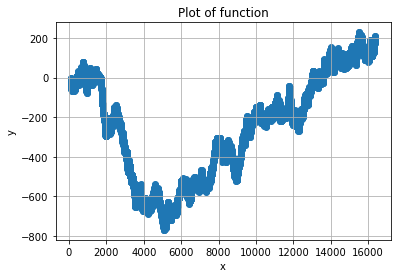

In [59]:
T = len(dates)
epsilon = 1
offset = 100
c_o = bad_con_obs(T, epsilon, dates, counts)
ys = np.zeros(len(dates)-offset)
start_date = datetime.strptime('2014-01-02','%Y-%m-%d').date()
start_date = start_date + timedelta(days=offset)
for i in range(offset,n_dates):
    #print(c_o.answer((str(start_date),str(dates[i]))))
    print(c_o.answer((str(start_date), str(dates[i]))))
    ys[i-offset] = (c_o.answer((str(start_date), str(dates[i]))) - ys[i-offset-1]) /14
xs = np.arange(100,n_dates)

fig = plt.figure(1)
p3 = plt.scatter(xs, ys)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of function')
plt.grid(True)
plt.show()

In [42]:
len(dates)

4096

In [43]:
len(xs)

3996

In [44]:
len(ys)

3996